- With this notebook we continue our analysis of `bikeshare` dataset.
- In this part we will do machine learning steps in order to predict the bike rentals for the given Kaggle test set and submit it to the Kaggle

![time](/images/timecycle.jpg)

<!-- TEASER_END -->

- In the previous post, we prepared the dataset partially 
- We created new columns and dropped the outliers regarding to the `"count"` column 
- Now we start by loading the dataset and continue to prepare it before applying machine learning algorithms

## Outline:
    
- About Time Data
- Trigonometric functions for cyclic time data transformation
- Data Split
- TimeSeriesSplit for the cross validation 
- Sklearn Pipeline
- Interpratation of RSMLE metric
- Creating a custom scoring function 
- Kaggle submission 

In [1]:
# Import the necessary modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline

import warnings 
warnings.filterwarnings("ignore")

%matplotlib inline
sns.set()

## Let's remind our dataset 

#### Kaggle terms for the dataset:

- The training set is comprised of the first `19 days` of each month, while the test set comprised of the days from `20th`  to the end of the month for each month. 

- Predict the `total count of bikes rented during each hour` covered by the test set, using only `information available prior to the rental period`.

Here is the [Kaggle link for the dataset](https://www.kaggle.com/c/bike-sharing-demand/data)

In [2]:
# Read the bike_data_inliers
bike_data=pd.read_csv("bike_data_inliers.csv", parse_dates=["datetime"], index_col="datetime")
bike_data.head(3)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,month,weekday,hour
datetime,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,1,5,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1,5,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,1,5,2


In [3]:
## Filter out the casual and registered columns and 
## high correlated columns "season" (correlated with "month") and "atemp" (correlated with "temp") should be omitted
## Also in the previous post we noticed that the data record in the "weather" column is not relaible
## We will also drop it
bike_data= bike_data.drop(["casual", "registered", "season", "atemp", "weather"], axis=1)
bike_data.head(3)

,holiday,workingday,temp,humidity,windspeed,count,month,weekday,hour
datetime,,,,,,,,,
2011-01-01 00:00:00,0,0,9.84,81,0.0,16,1,5,0
2011-01-01 01:00:00,0,0,9.02,80,0.0,40,1,5,1
2011-01-01 02:00:00,0,0,9.02,80,0.0,32,1,5,2


## About Time Data
- Since our data is a timeseries, i.e data recorded with a time dimension, we need to take into account the timeseries practices.


- Firstly, we need to be aware of the `cyclic` nature of our time data


- As we walked through the time frame charts in the previous post, we saw that ` month`  and `hour` variables are very predictive over the number of bike rentals. 


- This is very resaonable as we might expect that the bike usage and rentals during `January` is less than ` May` due to the weather conditions and rentals at `3am` in the morning is less than at `14h`, during the day. 


- So we should use the `"month"` and `"hour"` data as features for our models. However, we have a problem of how to utilize these features. 

- We need to keep them **numeric** for the machine learning algorithms but if we use them without any transformation, it would not be so smart practice. 

To make it clearer here is a question:
- Which one would you expect is more similar to the bike rentals in `January`: rentals in `December` or rentals in `May`? 


- Regarding the seasonal affects we can tell that number of bike rentals in `December` is more similar to rentals in `January`, however we represent `December` with number `12` and `May` with number `5`. 

- This is a wrong representation of the time features especially for the algorithms that use distance or the algorithms like linear regression.

> As an example let's assume our model is $$ bikerentals= 15+ 2*hour $$  
At 0h the number of estimated rentals = 15 <br>
At 23h the number of estimated rentals= 61 <br>
Even though there is only 1 hour difference between 0h-23h with this represantation the difference is the largest 


- Because of the cyclic nature of the months and hours we need to find a way of representing these features such that    
    - the `12th` month should be closer to `1st` month than `5th` month or 
    - `23th` hour should be closer to `1st` hour than `7th hour`. 

## Representation of  Cyclic Time Features
- We map each cyclical variable onto a circle such that the `lowest value` for that variable appears right next to the `largest value`. 

- We represent each variable with two components: x axis value and y axis value

- We compute the `x` and `y` components of that point using `sin` and `cos` functions. 

![hours](/images/hours.jpg)

- When we perform this transformation for the `"month"` variable, we also shift the values down by one such that it extends from `0 to 11`, for convenience

**NOTE:** Instead of represanting the time features with trigonometric functions we can also use dummy variables. Here we will go with the trigonometric functions

In [4]:
# Create the sin and cos components of hour, month and weekday columns
bike_data['hour_sin'] = np.sin(bike_data.index.hour*(2.*np.pi/24))
bike_data['hour_cos'] = np.cos(bike_data.index.hour*(2.*np.pi/24))
bike_data['month_sin'] = np.sin((bike_data.index.month-1)*(2.*np.pi/12))
bike_data['month_cos'] = np.cos((bike_data.index.month-1)*(2.*np.pi/12))
bike_data["weekday_cos"]= np.cos((bike_data.index.weekday)*(2.*np.pi/7))
bike_data['weekday_sin'] = np.sin((bike_data.index.weekday)*(2.*np.pi/7))

# Now we can drop the columns "month", "weekday" and "hour"
bike_data=bike_data.drop(["month", "weekday", "hour"], axis=1)

## Split the data
- Even though there is a given test set (without target variable) for Kaggle submission we will analyse the data as an independent project and follow our data splitting principles

- At the end we will use the Kaggle test set for submission

- So, after fitting a model we will use **cross validation** for evaluating model performance and hyperparameter tuning but we still we need to keep an **hold-out set** for our final evaluation. 

- Since this is a timeseries dataset we must respect to the temporal order of the data. Thus, we must use only the past data to predict the future data. 
- So we can take the **last %5** as our hold-out data. (In the Kaggle competition the test set is the last 10 days of the months)

- We need to split the data before doing transformation (incase we do) because test data points represent real-world data. 
- Transformation of the variables use information from the dataset like **mean** and **standard deviation**
- If we transform the data before splitting we take information like mean and variance of the whole dataset thus we will be **introducing future information to the training data**. 

- Therefore, we should perform transformation over the training data. Then perform the same transformation on testing data as well, but this time using the parameters (like mean and variance) of the training data. 

In [5]:
# Find the starting indice of the last five percent
last_five_percent_ind= int(len(bike_data)* 0.95)
last_five_percent_ind

# Create the hold-out dataset
hold_out_df=bike_data.reset_index().iloc[last_five_percent_ind: ,:]

print("The shape of the hold-out dataset:", hold_out_df.shape)
hold_out_df.head(3)

The shape of the hold-out dataset: (522, 13)


,datetime,holiday,workingday,temp,humidity,windspeed,count,hour_sin,hour_cos,month_sin,month_cos,weekday_cos,weekday_sin
9914,2012-11-16 06:00:00,0,1,12.30,61,6.0032,130,1.000000,6.123234e-17,-0.866025,0.5,-0.900969,-0.433884
9915,2012-11-16 07:00:00,0,1,12.30,61,11.0014,367,0.965926,-2.588190e-01,-0.866025,0.5,-0.900969,-0.433884
9916,2012-11-16 09:00:00,0,1,13.94,53,7.0015,351,0.707107,-7.071068e-01,-0.866025,0.5,-0.900969,-0.433884


We will do training and cross validation on the rest of the data. Lets create it

In [6]:
data= bike_data.reset_index().iloc[:last_five_percent_ind, :]
data.tail(3)

,datetime,holiday,workingday,temp,humidity,windspeed,count,hour_sin,hour_cos,month_sin,month_cos,weekday_cos,weekday_sin
9911,2012-11-16 03:00:00,0,1,12.3,65,8.9981,6,0.707107,0.707107,-0.866025,0.5,-0.900969,-0.433884
9912,2012-11-16 04:00:00,0,1,12.3,65,7.0015,5,0.866025,0.500000,-0.866025,0.5,-0.900969,-0.433884
9913,2012-11-16 05:00:00,0,1,12.3,65,6.0032,36,0.965926,0.258819,-0.866025,0.5,-0.900969,-0.433884


### Features and Target Variable
Having splitted the hold-out dataset, now time to create the features (X) and the target (y) datasets and fit a Linear Regression model

In [7]:
# Target data
y=data["count"]

# Features data
X=data.drop(["datetime", "count"], axis=1)

In [8]:
X.head(3)

,holiday,workingday,temp,humidity,windspeed,hour_sin,hour_cos,month_sin,month_cos,weekday_cos,weekday_sin
0,0,0,9.84,81,0.0,0.000000,1.000000,0.0,1.0,-0.222521,-0.974928
1,0,0,9.02,80,0.0,0.258819,0.965926,0.0,1.0,-0.222521,-0.974928
2,0,0,9.02,80,0.0,0.500000,0.866025,0.0,1.0,-0.222521,-0.974928


## Notes about Cross Validation of Timeseries Data

Here is the the notes from [sklearn official page](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation) :

Time series data is characterised by the **correlation between observations that are near in time (autocorrelation)**.

However, classical cross-validation techniques such as `KFold` and `ShuffleSplit` 
- assume the samples are **independent** and **identically distributed**, and 
- would result in unreasonable correlation between training and testing instances (yielding poor estimates of generalisation error) on time series data. 

Therefore, it is very important to evaluate our model for time series data on the “future” observations least like those that are used to train the model. 

### Time Series Split

`TimeSeriesSplit` is a variation of k-fold which 
- returns first `k` folds as train set and 
- the `k+1 th` fold as test set. 


- We should **not shuffle** our data when making predictions with timeseries.
- Unlike standard cross-validation methods, successive training sets are **supersets** of those that come before them. 
- Also, it adds all **surplus data** to the **first training partition**, which is always used to train the model.

## Sklearn Pipeline 
Whenever possible, using Sklearn Pipeline object is always a smart practice because they 
- are powerfull tools to standardise our operations,
- create an easy-to-understand workflow with clear order of steps,
- are reproducable

We will create a pipeline with `StandartScaler` and `LinearRegression` objects

In [9]:
# Instantiate the pipeline with the StandardScaler and  LinearRegression
pipeline=Pipeline(steps= [("scaler", StandardScaler()),
                          ("linreg", LinearRegression())])

## Cross validation scores

Let's use the `cross_val_score` from `sklearn.metrics` to get the scores of each split 

In [10]:
# Split the timeseries data
split = TimeSeriesSplit(n_splits=5)

# Fit and score the model with cross-validation
scores = cross_val_score(pipeline, X, y, cv=split)

print("R^2 scores of each split:", scores)

R^2 scores of each split: [0.27492746 0.32817026 0.19586317 0.37070607 0.41382806]


## Visualizing CV Splits for Timeseries: "TimeSeriesSplit"

Visualize the splits of cross validation with `TimeSeriesSplit` object

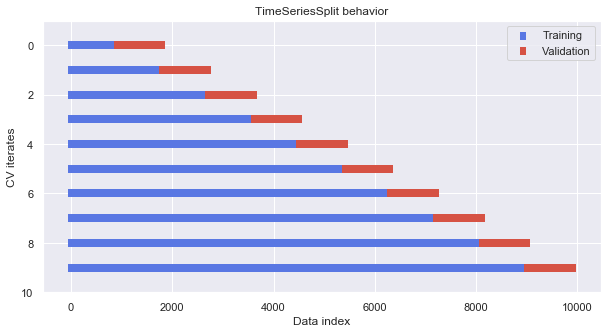

In [11]:
# Initialize the cross-validation iterator with 10 splits
cv = TimeSeriesSplit(n_splits=10)

fig, ax = plt.subplots(figsize=(10, 5)) 

# Loop over the cross validation splits
# cv.split() method creates train and test arrays for each split
for idx, (train, test) in enumerate(cv.split(X, y)):

    # Plot training and test indices
    indeces1 = ax.scatter(train, [idx] * len(train), c=[plt.cm.coolwarm(.1)], marker='_', lw=8)
    indeces2 = ax.scatter(test, [idx] * len(test), c=[plt.cm.coolwarm(.9)], marker='_', lw=8)
    
    ax.set(ylim=[10, -1], title='TimeSeriesSplit behavior', xlabel='Data index', ylabel='CV iterates')
    ax.legend([indeces1, indeces2], ['Training', 'Validation'])

## Scoring Metric: "RMSLE"

Lets try to understand the metric which we will use for the Kaggle evaluation. Here is the screen shot from the Kaggle evaluation page.

![scoring](/images/scoring.png)

Obviously it is of great importance to understand and use the metrics properly also in machine learning. Deriving insights without making clear sense of metrics is like to choosing between 1 litre of milk and 0.6 galon of milk. If we dont know the metrics litre and galon we can't make an healty decision.

So we need to take into account the metric `Root Mean Squared Log Error(RMSLE)` for this project but how can we interpret this metric?

![cost](/images/cost.jpg)


**Mechanism**: 

- It is the Root Mean Squared Error of the **log-transformed predicted** and **log-transformed actual values**. 
- `RMSLE` adds `1` to both actual and predicted values before taking the natural logarithm to avoid taking the natural log of possible `0 (zero)` values. 

- As a result, the function can be used if actual or predicted have **zero-valued** elements. But this function is not appropriate if either is **negative valued**

**Functionality:**

- The expression $$ log(p_i +1) − log(a_i+1)$$ can be written as $$ log((p_i+1) / (a_i+1)) $$ 

- RMSLE measures the ratio of predicted and actual.

>RMSLE is preferable when 
>- targets having exponential growth, such as population counts, average sales of a commodity over a span of years etc 
>- we care about **percentage errors** rather than the **absolute value of errors**.
>- there is a wide range in the target variables and
>- we **don’t want to penalize big differences** when **both the predicted and the actual are big numbers**.
>- we want to penalize **under estimates** more than **over estimates**.

Let's imagine two cases of predictions, 
- Case-1: our model predicts the number of bike rentals as `30` when the actual number is `40` 
- Case-2: our model predicts the number of rentals as `300` when the actual number is `400`

- With RMSE the second result is scored as `10 times` more than the first result
- Conversely, with RMSLogE two results are scored the same. 
- RMSLogE takes into account just the ratio of change

The decisions always depends on the domains or business cases and for the bike rentals business and the ranges of bike rentals this **"ratio of change"** feature of RMSLE looks like suitable.
<br>


Lets have a look at the below example

- Case-3 : 
    - Prediction = $600$, Actual = $1000$ (the absolute difference is $400$)

    - RMSE = $400$, 
    - RMSLogE = $0.5108$



- Case-4 : 
    - Prediction = $1400$, Actual = $1000$ (the absolute difference is $400$)

    - RMSE = $400$,
    - RMSLogE = $0.3365$
    
    

- When the differences are the same between **actual** and **predicted** in both cases. 
    - RMSE treated them equally, however 
    - RMSLogE penalized the under estimate more than over estimate (under estimated prediction score is higher than over estimated prediction score)
    
- This second feature (**penalizing the under estimate more than over estimate**) of RSMLE also looks plausible for bike business.
- Having extra bikes might be preferable to not being able to supply as many bikes as the demand. 
- Often **penalizing the under estimate more than over estimate** is important for prediction of sales and inventory demands.

## RSMLE Calculator Function

In [12]:
# Define the RMSLE function for error calculation: rmsle_calculator
# Using the vectorized numpy functions instead of loops always better for computation
def rmsle_calculator(predicted, actual):
    assert len(predicted) == len(actual)
    return np.sqrt(
                np.mean(
                    np.power(np.log1p(predicted)-np.log1p(actual), 2)))

## Custom Scoring Function

- Having defined our function for the RMSLE calculation, now we should define a scoring function in order to use as a scoring parameter for `model_selection.cross_val_score`

- We need this parameter for model-evaluation tools which rely on a scoring strategy when using cross-validation internally (such as `model_selection.cross_val_score` and `model_selection.GridSearchCV`) 
 
 
 We will use `make_scorer` function of Sklearn to generate a callable object (from our `rsmle_calculator` function) for scoring. <br>
When defining a custom scorer via `sklearn.metrics.make_scorer`, the convention is that 
- custom functions ending in `_score` return a value to maximize and
- for scorers ending in `_loss` or `_error`, a value is returned to be minimized. 
- We can use this functionality by setting the `greater_is_better` parameter inside `make_scorer`. 
- This parameter would be 
    - `True` for scorers where higher values are better, and
    - `False` for scorers where lower values are better. (this will be our choise since the lower RSMLE values are better)

**NOTE:**
-  If a loss, the output of the python function, is negated by the scorer object, conforming to the cross validation convention; that scorers return higher values for better models i.e
- when `greater_is_better` is `False`, the scorer object will sign-flip the outcome of the `score_func`.

In [13]:
# Make a custom scorer 
# rmsle_error will negate the return value of rmsle_calculator,
rmsle_error = make_scorer(rmsle_calculator, greater_is_better=False)

# Fit and score the model with cross-validation
scores = cross_val_score(pipeline, X, y, cv=split, scoring=rmsle_error)
scores

As explained the scores are negative due to the Sklearn customs. We can multiply the results by `-1` for our interpretation

In [15]:
print("The cross validation scores:", scores*-1)

The cross validation scores: [1.06115722 0.97511162 1.02056734 0.93509628 0.92447915]


## Hold-out Data Prediction Scores

In [16]:
# Hold-out target data 
y_hold=hold_out_df["count"]

# Hold-out features data
X_hold=hold_out_df.drop(["datetime", "count"], axis=1)

# Fit the pipeline to train data
pipeline.fit(X, y)

# Generate predictions for hold-out data
predictions_hold = pipeline.predict(X_hold)

# R^2 score
score = r2_score(y_hold, predictions_hold)

print("R^2 score of hold-out:", score)
print("Root mean squared error of hold-out:", np.sqrt(mean_squared_error(y_hold, predictions_hold)))
print ("RMSLE value for linear regression of hold-out: ", rmsle_calculator(y_hold , abs(predictions_hold)))

R^2 score of hold-out: 0.3889173616885714
Root mean squared error of hold-out: 120.48857034926871
RMSLE value for linear regression of hold-out:  0.715555147546642


## Kaggle submission
Lets predict the given Kaggle test set and submit the predictions to Kaggle to get our score. <br>
First it would be better if we combine our `X` and `X_hold` and `y` and `y_hold` datasets then train our model with more data in order to let our model learn better before predicting on a new test data i.e Kaggle test dataset which we have not yet uploaded.

In [17]:
# Combine X and X hold: combined_train
combined_X=pd.concat([X, X_hold])

# Combine the y and y hold: combined_test
combined_y =pd.concat([y, y_hold])

# Fit the model to the combined datasets
pipeline.fit(combined_X, combined_y)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linreg', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [18]:
# Read the Kaggle test data
kaggle_test=pd.read_csv("bike_kaggle_test.csv", parse_dates=["datetime"], index_col="datetime")
kaggle_test.head(3)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
datetime,,,,,,,,
2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000


Lets also apply all the steps that we followed for train data to the test data in order to conform the train and test datasets

In [19]:
kaggle_test["month"]=kaggle_test.index.month
kaggle_test["weekday"]=kaggle_test.index.dayofweek
kaggle_test["hour"]=kaggle_test.index.hour

# Create the sin and cos components of hour, month and weekday columns
kaggle_test['hour_sin'] = np.sin(kaggle_test.hour*(2.*np.pi/24))
kaggle_test['hour_cos'] = np.cos(kaggle_test.hour*(2.*np.pi/24))
kaggle_test['month_sin'] = np.sin((kaggle_test.month-1)*(2.*np.pi/12))
kaggle_test['month_cos'] = np.cos((kaggle_test.month-1)*(2.*np.pi/12))
kaggle_test["weekday_cos"]= np.cos((kaggle_test.weekday)*(2.*np.pi/7))
kaggle_test['weekday_sin'] = np.sin((kaggle_test.weekday)*(2.*np.pi/7))

# Drop the wrong represantation of time: month, weekday, hour
# Drop the correlated features: atemp, season
# Drop the weather column (not relaible data records)
X_kaggle_test= kaggle_test.drop(["season", "month", "weekday", "hour", "atemp", "weather"], axis=1)
X_kaggle_test.head(3)

,holiday,workingday,temp,humidity,windspeed,hour_sin,hour_cos,month_sin,month_cos,weekday_cos,weekday_sin
datetime,,,,,,,,,,,
2011-01-20 00:00:00,0,1,10.66,56,26.0027,0.000000,1.000000,0.0,1.0,-0.900969,0.433884
2011-01-20 01:00:00,0,1,10.66,56,0.0000,0.258819,0.965926,0.0,1.0,-0.900969,0.433884
2011-01-20 02:00:00,0,1,10.66,56,0.0000,0.500000,0.866025,0.0,1.0,-0.900969,0.433884


Our Kaggle test dataset is in the same structure with our `combined_X` dataset. Time to predict and submit!

In [20]:
final_predictions=pipeline.predict(X_kaggle_test)

Having predicted the test targets now we need to create a dataframe complying with Kaggle submission format like shown in the screenshot
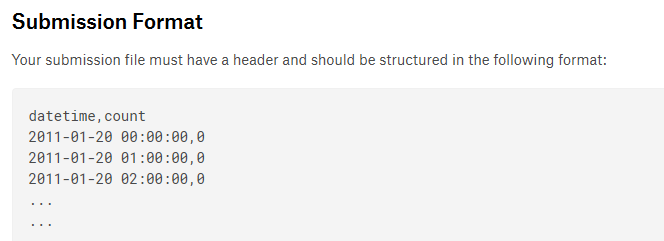

In [21]:
kaggle_sub=pd.DataFrame({"datetime":kaggle_test.index, "count":final_predictions}).set_index("datetime")
kaggle_sub["count"]=kaggle_sub["count"].abs()
kaggle_sub.head(3)

,count
datetime,
2011-01-20 00:00:00,29.463588
2011-01-20 01:00:00,32.955071
2011-01-20 02:00:00,22.045803


In [22]:
# Save the submission dataframe
kaggle_sub.to_csv("kaggle_sub.csv")

## Kaggle Submission Score

When we fit our model to the Kaggle test set and submited we got the score below. This competition is closed so there is no ranking anymore but to get a bit of idea about our model's performance the mean ranking and the two scores in the ranking that our score fall in between were below. 
<br>

For the start of our project this is a pretty good score. 
- We have just tried Linear Regression so far and also 
- we did not used new features except from the time features. 
- Later we can work more on this and i think our ranking can get better

Our score:
![kaggle1](/images/kaggle1.jpg)

Mean value benchmark:

![kaggle2](/images/kaggle2.jpg)

The ranking that our score falls in

![kaggle3](/images/kaggle3.jpg)

## Wrap Up

This was the second part of our analysis on bikeshare dataset <br>

In this notebook we

- continued to prepare our dataset for machine learning
- used the trigonometric function for time data transformation in order to better represent the cyclic nature of time features
- splitted our data set and keep an hould-out test set for final evaluation
- used `TimeSeriesSplit` iterators for the cross validation of timeseries data. This was important in order to only using past data to evaluate our model on the “future” observations 
- used Sklearn Pipeline for better workflow
- understood the mechanism and the functionality of the RSMLE metric
- created a custom scoring function which uses RSMLE for the sklearn model evaluation tools 
- prepared and predicted the Kaggle testset and made a submission

In the next post we will continue our analysis of bikeshare data with tree-based models and focus on model performance especially with visualization tools

Sources:<br>
https://scikit-learn.org/stable/modules/model_evaluation.html#defining-your-scoring-strategy-from-metric-functions<br>
http://blog.davidkaleko.com/feature-engineering-cyclical-features.html <br>
https://www.quora.com/What-is-the-difference-between-an-RMSE-and-RMSLE-logarithmic-error-and-does-a-high-RMSE-imply-low-RMSLE